In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set()
import os
import sklearn

In [22]:
df  = pd.read_csv(os.path.join('Datos','Transformados', 'df_transformado.csv'))
df.sample()

,asset,asset_type,brand,segment,checkin_time,checkout_time,booking_time,adult_count,child_count,origin,...,cancelled_imp,dif_can_in,dif_can_res,dif_ent_res,duracion_reserva,extras_net_value,rangos_age,total_personas,rangos_adultos,rangos_niños
1070,Líbere Bilbao Museo,apartment,libere,Leisure Individual,2022-04-05 12:50:00,2022-04-12 09:00:00,2022-03-20 18:58:13,2,1,channel_manager,...,2000-01-01 00:00:00,0,0,16,7,0.0,35-50,3,pareja,niño unico


In [23]:
df_abandonistas = df[df['cancellation'] == True]
df_compradores = df[df['cancellation'] == False]

In [24]:
medias_compradores = df_compradores.mean()
medias_compradores = pd.DataFrame(medias_compradores)
medias_compradores.columns = ['medias_compr']

/tmp/ipykernel_8960/4094614269.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medias_compradores = df_compradores.mean()


In [25]:
medias_abandonistas = df_abandonistas.mean()
medias_abandonistas = pd.DataFrame(medias_abandonistas)
medias_abandonistas.columns = ['medias_aband']

/tmp/ipykernel_8960/2322381138.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medias_abandonistas = df_abandonistas.mean()


In [26]:
comparacion = pd.concat([medias_compradores,medias_abandonistas], axis = 1)

In [27]:
comparacion

,medias_compr,medias_aband
adult_count,2.358320,2.472000
child_count,0.289098,0.295158
age,39.982908,39.905263
recurrence,1.492248,1.141053
product_count,0.816750,0.480842
reservation_net_value,241.540674,337.579600
reservation_nights_net_value,231.527332,328.112362
cancellation,0.000000,1.000000
age_nan,0.004761,0.764632
dif_can_in,0.000000,16.353263


Clustering de compradores

In [28]:
from sklearn.decomposition import PCA
import pandas as pd
col_names = ['adult_count', 'child_count', 'reservation_net_value', 'total_personas', 'age', 'recurrence', 'dif_can_in', 'dif_can_res', 'dif_ent_res', 'duracion_reserva']
modelado = df_compradores[col_names]
x = modelado.values[:, :]

reduced_data = PCA(n_components=3).fit_transform(x)
reduced_data

array([[-201.08120338,  -11.12660086,  -11.95137555],
       [ -65.35314014,  -12.33271332,    7.56444836],
       [-165.96570041,  -12.60572733,  -14.04941056],
       ...,
       [ 154.76285169,  -12.90121142,   12.76338113],
       [-169.01531877,  -10.27485512,   -2.09295597],
       [-173.19751254,  -11.22542129,   -2.05082449]])

For n_clusters = 2 The average silhouette_score is : 0.7459421857313121
For n_clusters = 3 The average silhouette_score is : 0.6831155019742964
For n_clusters = 4 The average silhouette_score is : 0.6113779114464736
For n_clusters = 5 The average silhouette_score is : 0.5835560207767464
For n_clusters = 6 The average silhouette_score is : 0.5704370750323208


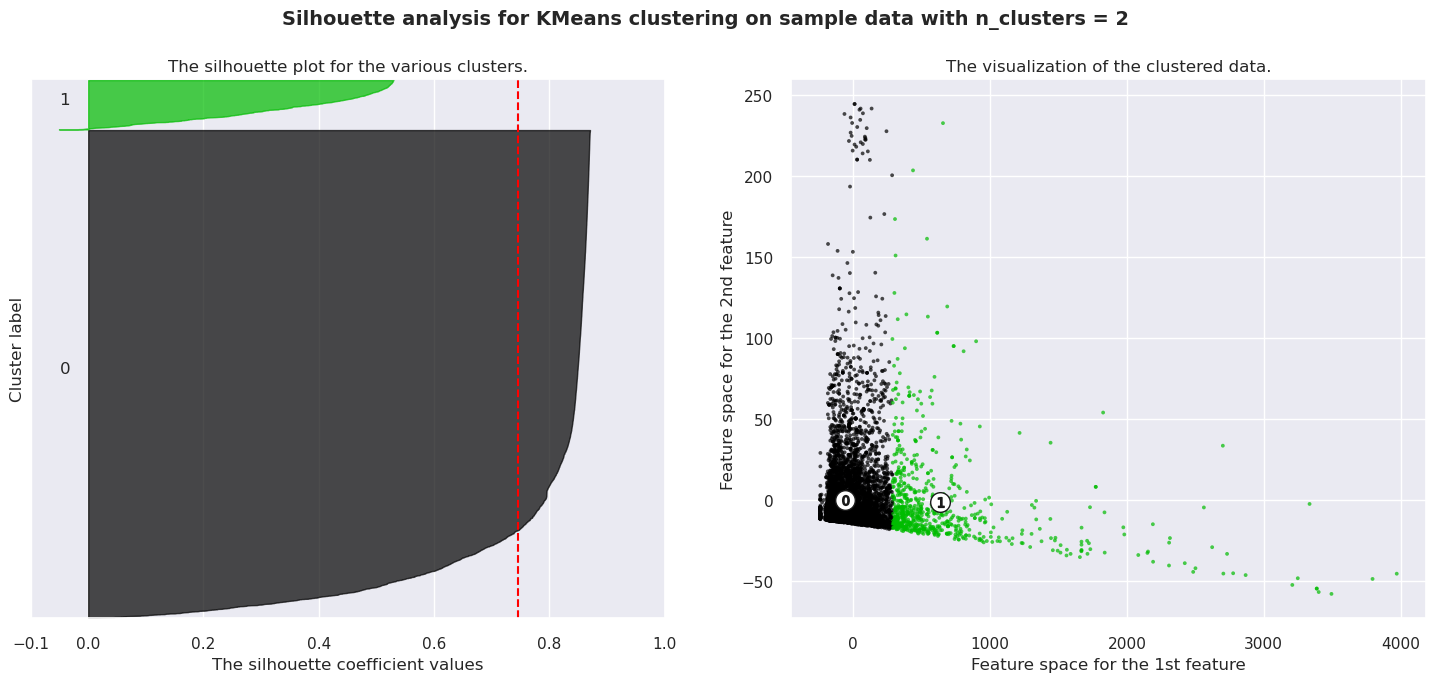

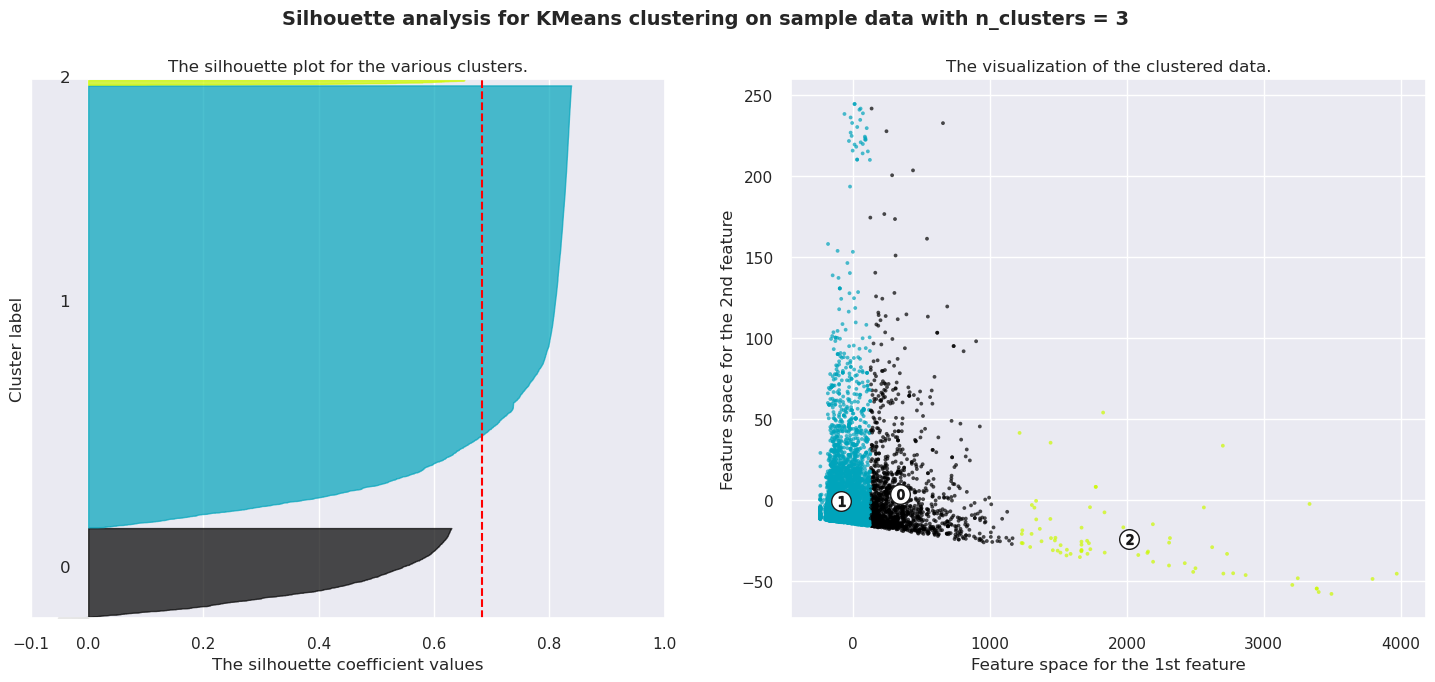

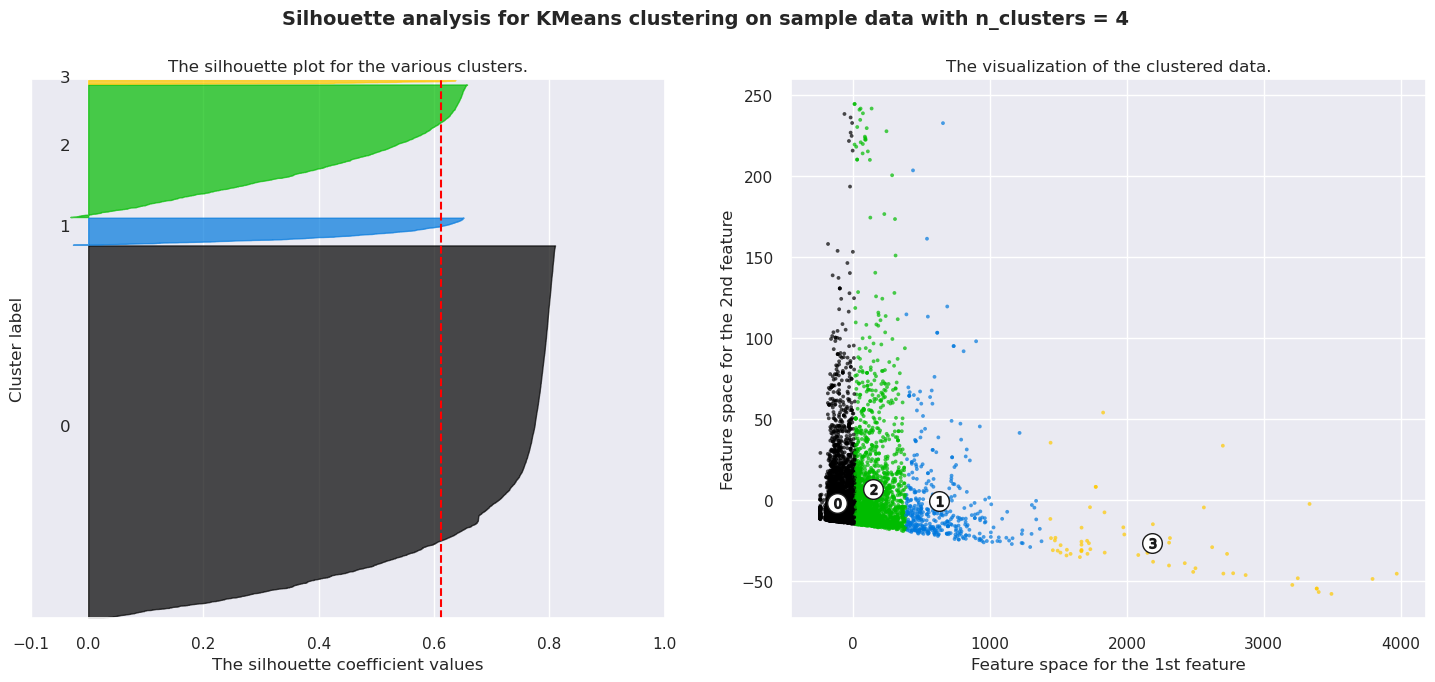

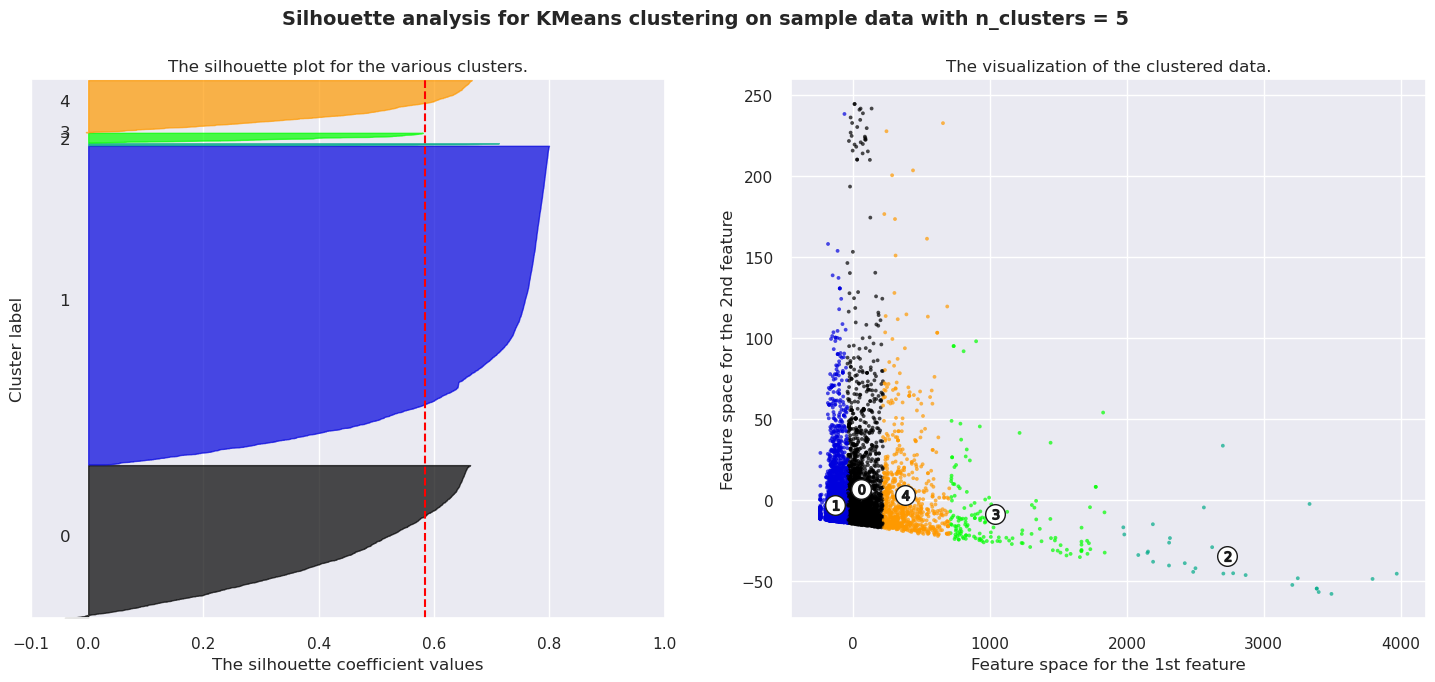

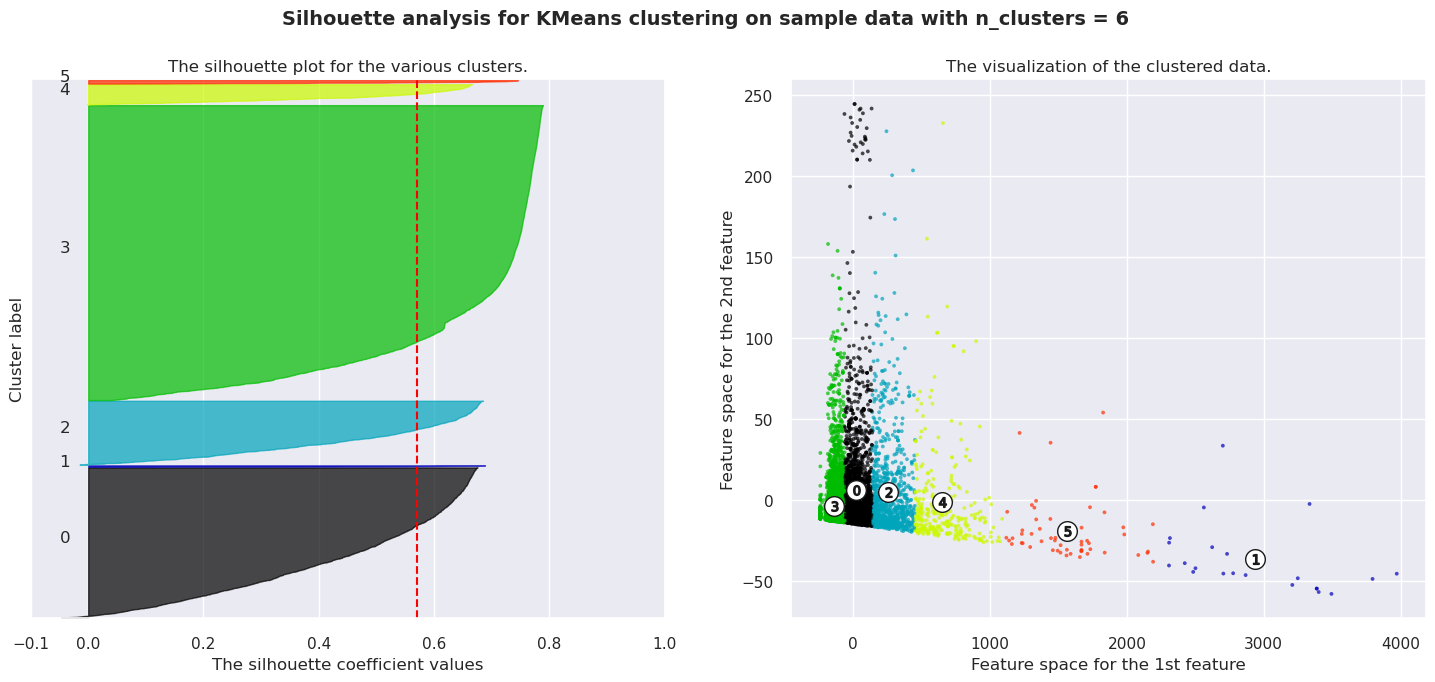

In [29]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Feature space for the 2nd feature')

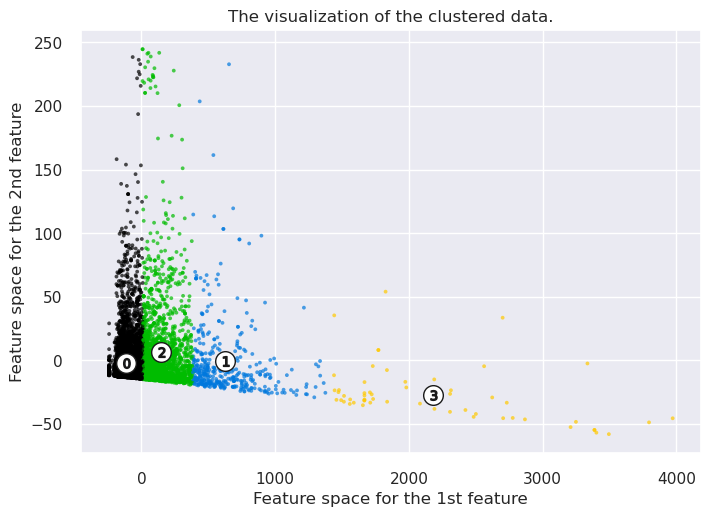

In [30]:
modelo = KMeans(n_clusters=4, random_state=10)
y_clusters_k = modelo.fit_predict(reduced_data)
colors = cm.nipy_spectral(y_clusters_k.astype(float) / 4)
fig, ax2 = plt.subplots()
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
centers = modelo.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

In [31]:
clusters = pd.concat([modelado,pd.DataFrame(y_clusters_k)], axis = 1).rename(columns = {0:'cluster_kmeans_compr'})
clusters.groupby('cluster_kmeans_compr').size()

cluster_kmeans_compr
0.0    5693
1.0     414
2.0    2026
3.0      58
dtype: int64

Clustering de los abandonistas

In [32]:
from sklearn.decomposition import PCA
import pandas as pd
col_names = ['adult_count', 'child_count', 'reservation_net_value', 'total_personas', 'age', 'recurrence', 'dif_can_in', 'dif_can_res', 'dif_ent_res', 'duracion_reserva']
modelado = df_abandonistas[col_names]
x = modelado.values[:, :]

reduced_data = PCA(n_components=3).fit_transform(x)
reduced_data

array([[-2.64480584e+02, -3.00252647e+01,  1.46370390e-01],
       [-5.47190579e+01, -2.04916505e+01, -6.62836091e+00],
       [-2.28594960e+02,  1.87749908e+00, -1.33853852e+01],
       ...,
       [-8.17856806e+01,  3.53876279e+01, -2.96370934e+01],
       [-1.30400669e+02,  3.90171861e+01, -2.55851659e+01],
       [-1.64125348e+02, -2.35005669e+01, -3.83095111e+00]])

For n_clusters = 2 The average silhouette_score is : 0.7747235565712123
For n_clusters = 3 The average silhouette_score is : 0.6624723926254799
For n_clusters = 4 The average silhouette_score is : 0.5897712966001462
For n_clusters = 5 The average silhouette_score is : 0.5895112320629575
For n_clusters = 6 The average silhouette_score is : 0.5410153250727714


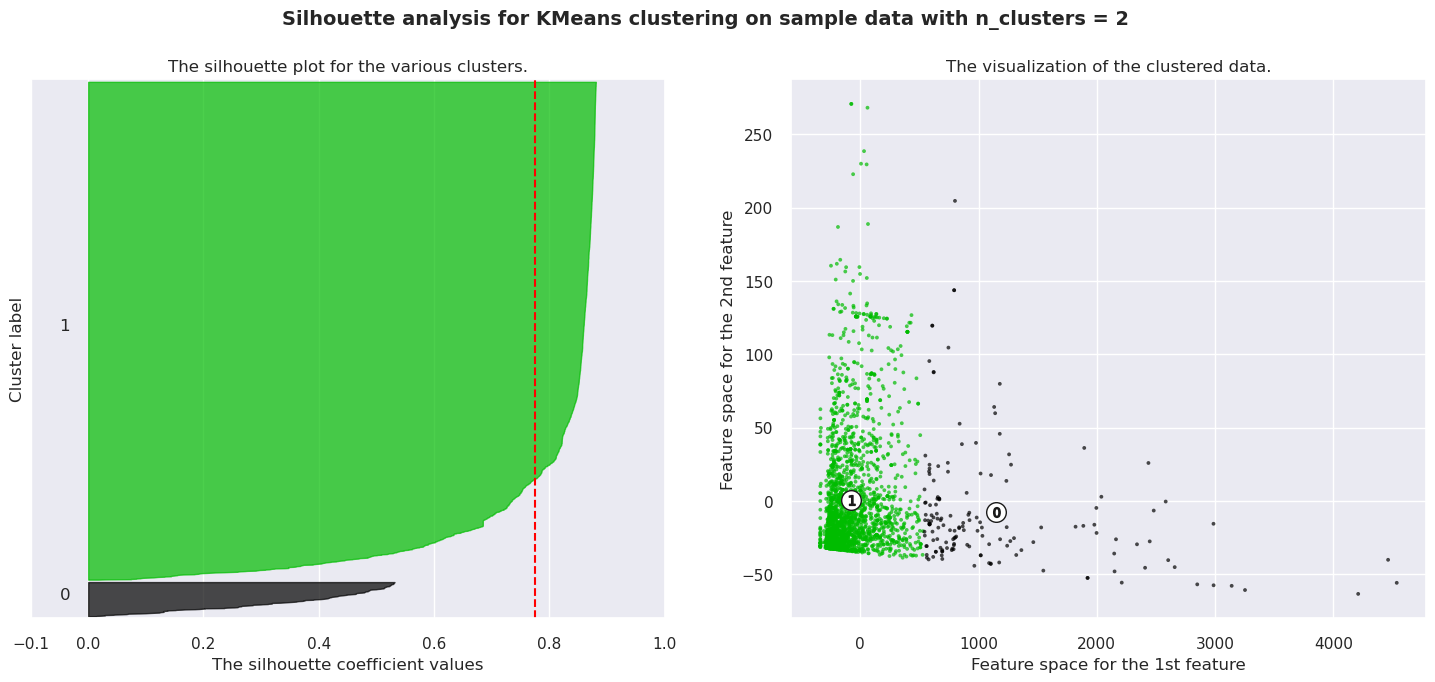

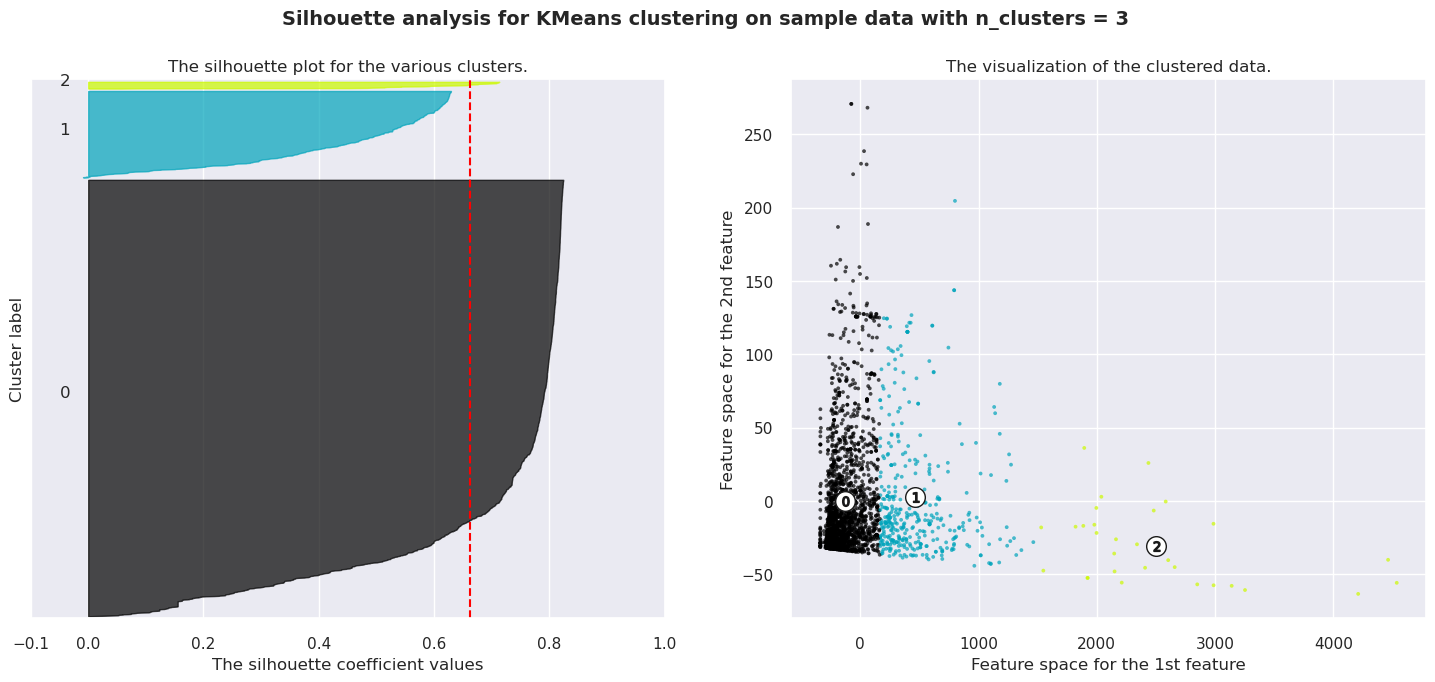

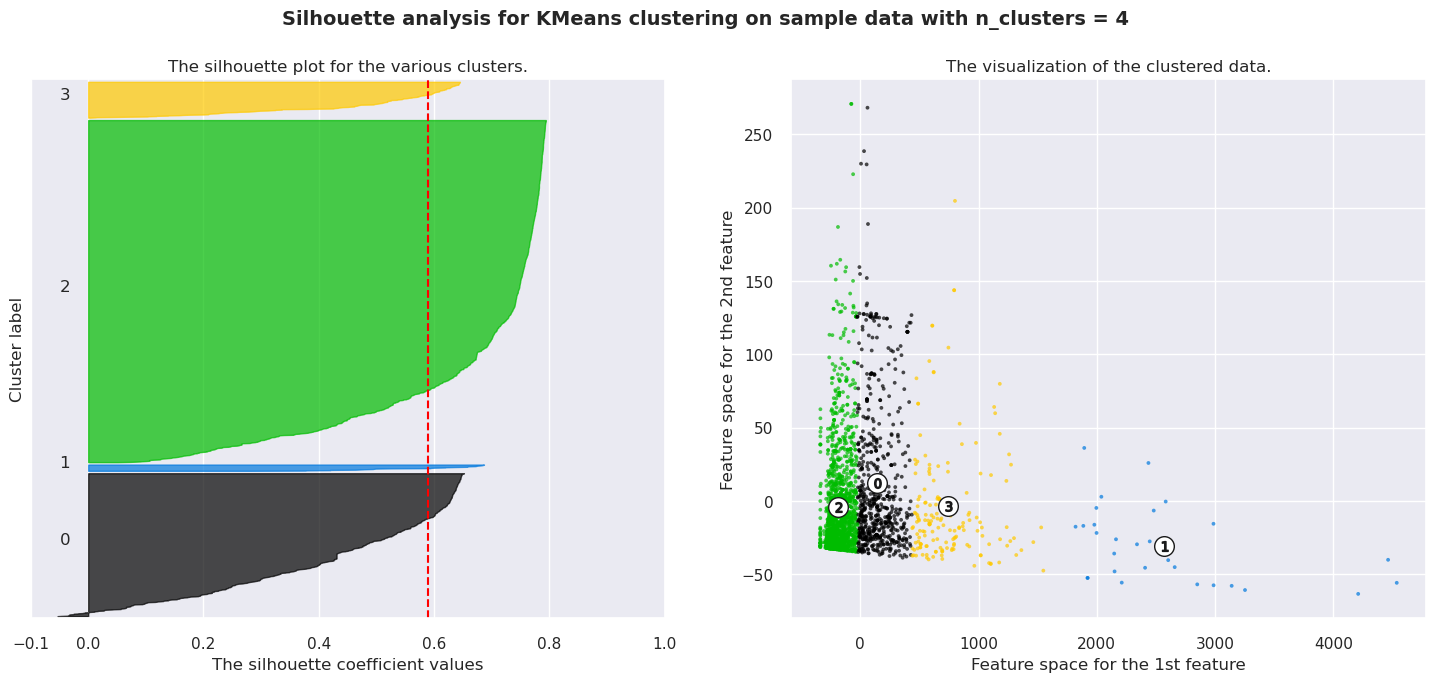

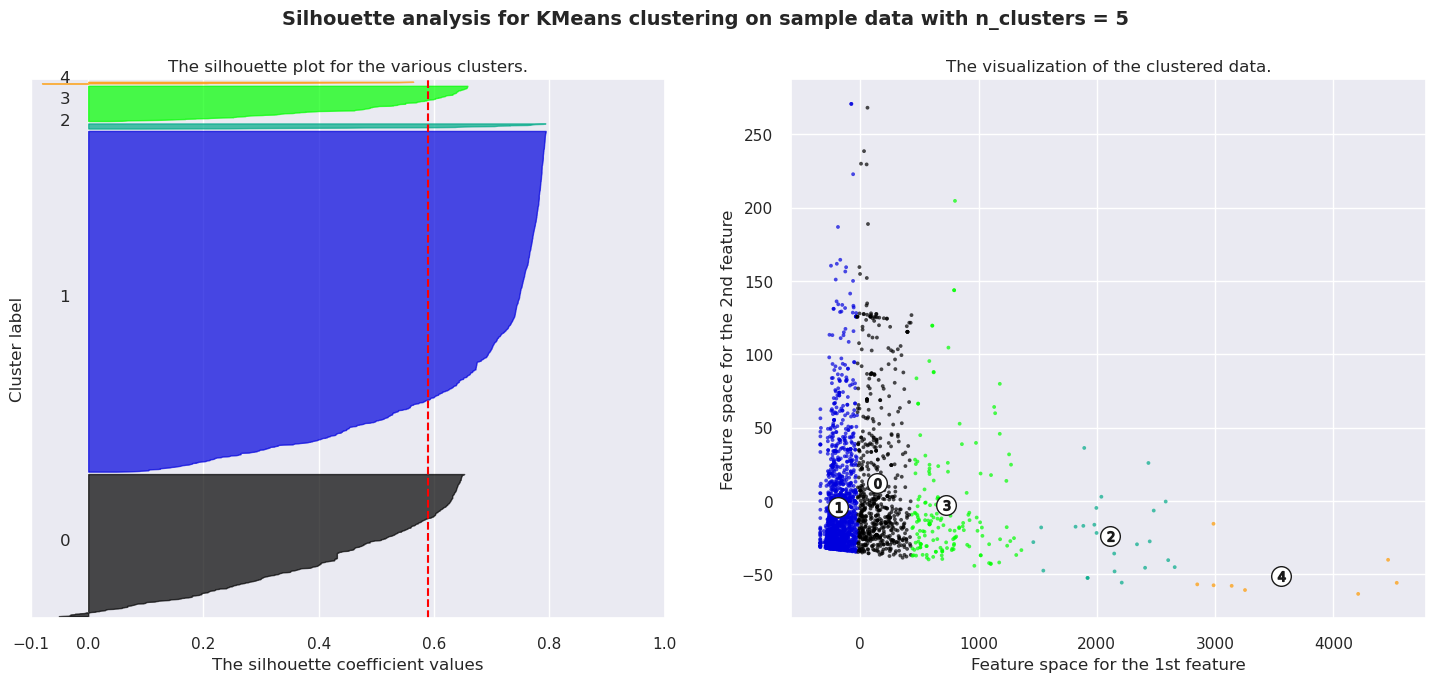

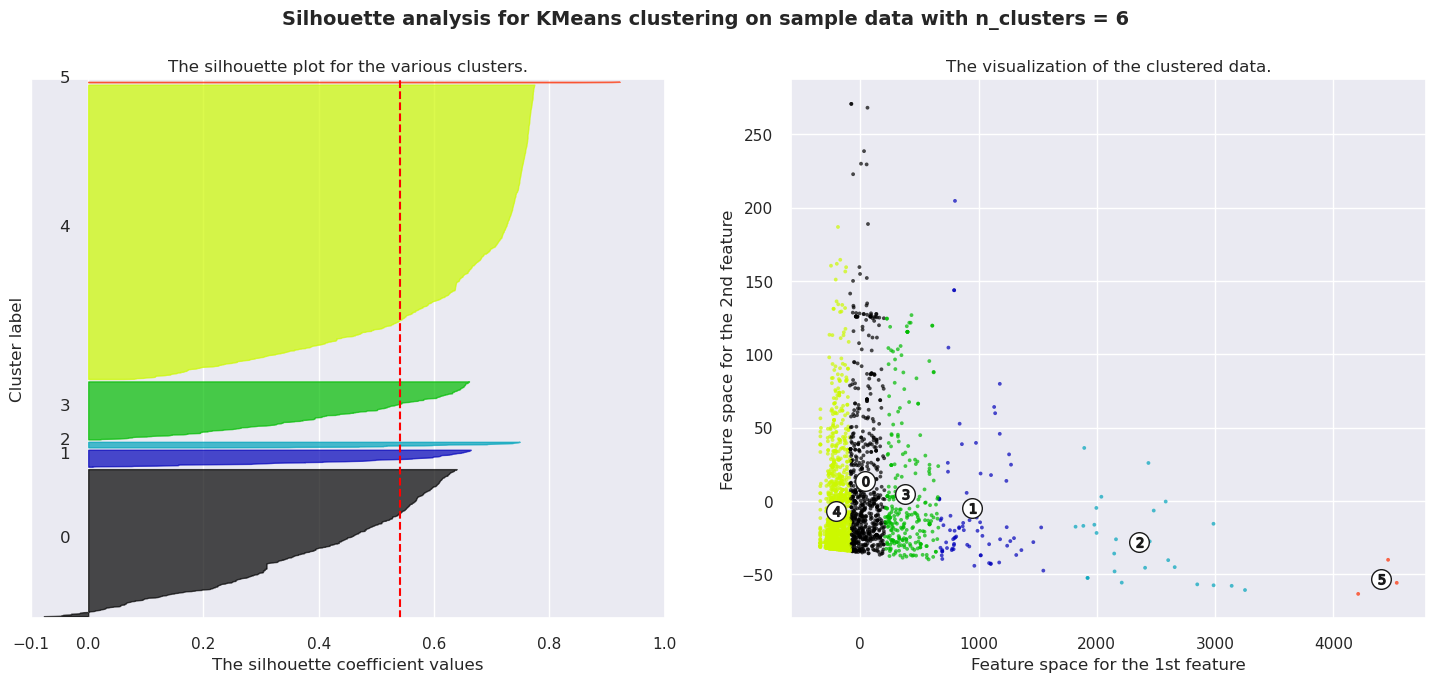

In [33]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import pandas as pd

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(reduced_data) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(reduced_data)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(reduced_data, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(reduced_data, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

Text(0, 0.5, 'Feature space for the 2nd feature')

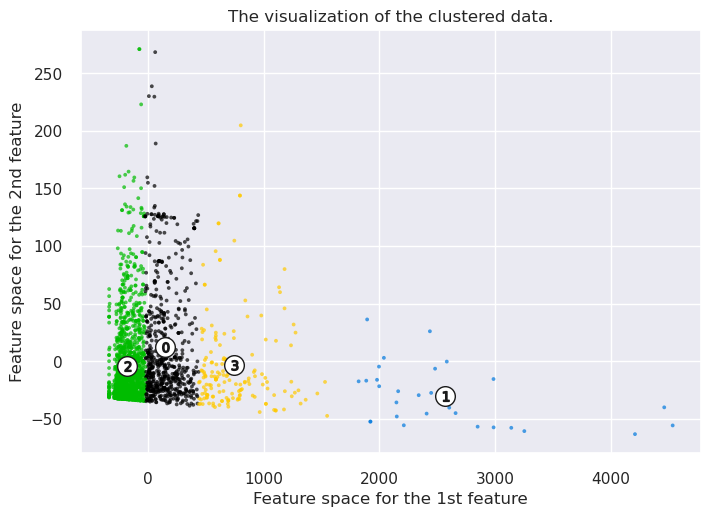

In [34]:
modelo = KMeans(n_clusters=4, random_state=10)
y_clusters_k = modelo.fit_predict(reduced_data)
colors = cm.nipy_spectral(y_clusters_k.astype(float) / 4)
fig, ax2 = plt.subplots()
ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
centers = modelo.cluster_centers_
# Draw white circles at cluster centers
ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
            c="white", alpha=1, s=200, edgecolor='k')
for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

ax2.set_title("The visualization of the clustered data.")
ax2.set_xlabel("Feature space for the 1st feature")
ax2.set_ylabel("Feature space for the 2nd feature")

In [35]:
clusters = pd.concat([clusters,pd.DataFrame(y_clusters_k)], axis = 1).rename(columns = {0:'cluster_kmeans_aband'})
clusters.groupby('cluster_kmeans_aband').size()

cluster_kmeans_aband
0.0     644
1.0      29
2.0    1540
3.0     162
dtype: int64

In [37]:
medias_cluster_aband = clusters.groupby('cluster_kmeans_aband').mean()
medias_cluster_aband['tamaño_grupo'] = clusters.groupby('cluster_kmeans_aband').size()
medias_cluster_aband = medias_cluster_aband.sort_values('tamaño_grupo', ascending = False)
medias_cluster_aband

,adult_count,child_count,reservation_net_value,total_personas,age,recurrence,dif_can_in,dif_can_res,dif_ent_res,duracion_reserva,cluster_kmeans_compr,tamaño_grupo
cluster_kmeans_aband,,,,,,,,,,,,
2.0,2.474359,0.339316,250.915838,2.813675,38.452137,1.447009,0.0,0.000855,12.394872,2.406838,0.729870,1540
0.0,2.494000,0.352000,213.275640,2.846000,38.754000,1.342000,0.0,0.000000,13.372000,1.998000,0.621118,644
3.0,2.663793,0.293103,208.841724,2.956897,37.017241,1.362069,0.0,0.000000,13.801724,1.879310,0.512346,162
1.0,3.360000,0.200000,242.721200,3.560000,43.680000,1.280000,0.0,0.000000,12.200000,1.880000,0.793103,29


In [38]:
medias_cluster_compr = clusters.groupby('cluster_kmeans_compr').mean()
medias_cluster_compr['tamaño_grupo'] = clusters.groupby('cluster_kmeans_compr').size()
medias_cluster_compr = medias_cluster_compr.sort_values('tamaño_grupo', ascending = False)
medias_cluster_compr

,adult_count,child_count,reservation_net_value,total_personas,age,recurrence,dif_can_in,dif_can_res,dif_ent_res,duracion_reserva,cluster_kmeans_aband,tamaño_grupo
cluster_kmeans_compr,,,,,,,,,,,,
0.0,2.530500,0.329906,247.647471,2.860407,39.548092,1.505826,0.0,0.000228,14.206077,2.433630,1.495968,5693
2.0,2.351140,0.315309,273.723244,2.666450,40.300977,1.559609,0.0,0.000000,13.057980,2.639088,1.530670,2026
1.0,2.312303,0.372240,292.640473,2.684543,39.400631,1.435331,0.0,0.000000,14.384858,2.555205,1.557576,414
3.0,2.333333,0.333333,264.286889,2.666667,39.222222,1.266667,0.0,0.000000,11.488889,2.333333,1.857143,58
